<a href="https://colab.research.google.com/github/jhu-nanoenergy/VAE-models/blob/main/AE_framework_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Helpful tutorial / example links
# https://github.com/timbmg/VAE-CVAE-MNIST/blob/master/models.py
# https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/


In [ ]:
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.stats as stat
import pandas as pd
import numpy as np
import os
import random

import torch
import torchvision
import torch.optim as optim
import argparse
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import h5py



In [ ]:


from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

plt.style.use('ggplot')

Mounted at /content/drive/


In [ ]:
# torch.cuda.empty_cache()
# import gc
# del hdf_file, data_temp, data_test, data_val
# gc.collect()

In [ ]:
full_data_num = 15000 #amount of data to use from EACH int / ext dataset


latent_features = 16
epochs = 100
lr = 0.0001

spec_points = 219


In [ ]:


# Get all data from drive
int_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/int_total_sqr_no_struct.mat', squeeze_me=True)
# ext_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/ext_total_sqr_no_struct.mat', squeeze_me=True)
wavelengths = int_data_all['lambda']
wavelengths = np.delete(wavelengths,np.where(wavelengths==[0.5]))
wavelengths = np.delete(wavelengths,np.where(wavelengths==[1]))
wavelengths = np.transpose(np.tile(wavelengths,(3,1)))

In [ ]:
print(np.shape(wavelengths))

(219, 3)


In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
fname_mask = '/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData.h5'

hdf_file = h5py.File(fname_mask, "r")
print(list(hdf_file.keys()))
dext = hdf_file['ext']

dext_spectra = hdf_file['ext/spectCell']
dint_spectra = hdf_file['int/spectCell']

combined = np.concatenate((dext_spectra,dint_spectra), axis=0)

print(dext.keys())
print(np.shape(combined))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
class ImageDataset(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ):
        super(Dataset, self).__init__()
        dext_height = hf['ext/height']
        dint_height = hf['int/height']
        dext_spectra = hf['ext/spectCell']
        dint_spectra = hf['int/spectCell']
        self.spectra = torch.from_numpy(np.concatenate((dext_spectra[:datanum], dint_spectra[:datanum]), axis=0))
        
        self.heights = torch.from_numpy(np.concatenate((dext_height[:datanum],dint_height[:datanum]), axis=0))
        # self.heights = htemp.unsqueeze(1)

        self.masks = np.concatenate((hf['ext/maskCell'][:datanum],hf['int/maskCell'][:datanum]), axis=0)
        self.sizes =  torch.from_numpy(np.concatenate((hf['ext/size'][:datanum],hf['int/size'])[:datanum], axis=0))
        ext_label = np.ones((np.shape(dext_height)))
        int_label = np.zeros((np.shape(dint_height)))
        self.labels = torch.from_numpy(np.concatenate( (ext_label, int_label), axis=0))
        self.transform = transform  
              

    def __len__(self):
        return len(self.heights)

    def __getitem__(self, idx):
        image = (self.masks[idx,:,:])
        # height= np.around( self.heights[idx], decimals=1)
        spectra = (( self.spectra[idx] ))
        if self.transform:
            image = self.transform(image)
        return image, spectra
        # return image, spectra, height

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    # encoder
    self.enc1 = nn.Linear(in_features=(256*256), out_features=1024)
    # prediction network
    self.pred1 = nn.Linear(in_features=1024, out_features=(spec_points*3))

    # recognition network
    self.rec1 = nn.Linear(in_features=1024 + (spec_points*3), out_features=latent_features*2)



  def forward(self, x):
    # encoding
    e = F.relu(self.enc1(x))
    
    p = torch.sigmoid(self.pred1(e))
    

    input_rec = torch.cat((e,p), 1)

    x = self.rec1(input_rec).view(-1, 2, latent_features)

    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance


    return p, mu, log_var

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    # decoder 
    self.dec1 = nn.Linear(in_features= spec_points*3 +latent_features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=(256*256))



  def forward(self, spectra,latent):
    # encoding
    input_dec = torch.cat((spectra,latent),1)

    # decoding
    x = F.relu(self.dec1(input_dec))
    reconstruction = torch.sigmoid(self.dec2(x))
    return reconstruction 

In [ ]:
# # Linear VAE example that includes random parameterization........
# define a simple linear VAE

class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
      
        spectra, mu, log_var  = self.encoder(x)        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder( spectra, z )
        return recon_x, mu, log_var, spectra

    # DEFINE SPECTRA PREDICTION FUNCTION 


    def inference(self, spectra, z):
      recon_x = self.decoder( spectra, z )
      return recon_x



In [ ]:
# DEFINE RANDOM SEED 
# CREATE VALIDATION SET AND FIX MEMORY ISSUES AHHHHHHHHHHH
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
full_dataset = ImageDataset(hdf_file, full_data_num )

In [ ]:

# print(torch.cuda.memory_summary(device=None, abbreviated=False))
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
data_temp, data_test = torch.utils.data.random_split(full_dataset, [train_size+val_size, test_size])

data_train, data_val = torch.utils.data.random_split(data_temp, [train_size, val_size])
bsize = 10 #don't make batch size bigger 
train_dataloader = DataLoader(data_train, batch_size = bsize, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size = bsize)
valid_dataloader = DataLoader(data_val, batch_size = bsize)
print(len(train_dataloader))
print(len(test_dataloader))
print(len(valid_dataloader))

2100
300
600


In [ ]:
print(len(full_dataset))

30000


In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
model_custom = LinearVAE().cuda()
optimizer = optim.Adam(model_custom.parameters(), lr=lr)
criterion_mask = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss()

In [ ]:
def final_loss(loss1_bce, loss2_mse, mu, logvar):
    """
    This function will add the reconstruction loss and the  KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    alpha = 100

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (loss1_bce + 100*loss2_mse + KLD)



In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataloader)/dataloader.batch_size)):
      if torch.cuda.is_available():
        data, spectra_in = [d.cuda( ) for d in data]
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar, out_spectra = model(data)
        pout = out_spectra.view(-1, 3, spec_points)        
        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader, plot_on):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataloader)/dataloader.batch_size)):
        data, spectra_in = [d.cuda( ) for d in data]
        data = data.view(data.size(0), -1)
        reconstruction, mu, logvar, out_spectra = model(data)
        pout = out_spectra.view(-1, 3, spec_points)
        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()

        # save the last batch input and output 
        if plot_on:
          if i == int(len(valid_dataloader)/dataloader.batch_size) - 1:
        # if i == 14:   
        # if i == 1:
            # both = torch.cat((data.view(batch_size, 1, 256, 256)[:4],  
            #                   reconstruction.view(batch_size, 1, 256, 256)[:4]))
            print("MSE loss: " + str(mse_loss))
            num_replicas = 4
            fig, axs = plt.subplots(2,num_replicas)
            for x in range( num_replicas ):
      
              axs[0,x].imshow(torch.squeeze(data.view(bsize, 1, 256, 256)[x]).cpu())
              axs[0,x].xaxis.set_visible(False)
              axs[0,x].yaxis.set_visible(False)
              axs[1,x].imshow(torch.squeeze(reconstruction.view(bsize, 1, 256, 256)[x]).cpu())
              axs[1,x].xaxis.set_visible(False)
              axs[1,x].yaxis.set_visible(False)
            fig.suptitle(str(epoch+1))

            og = spectra_in[0].detach().cpu().numpy()
            pred = pout[0].detach().cpu().numpy()
            
            # pout = p.view(-1, 3, spec_points)
            fig2, axs = plt.subplots(2,1)
            axs[0].plot(wavelengths, np.transpose(og) )
            axs[1].plot(wavelengths, np.transpose(pred) )
            fig2.suptitle(str(epoch+1))
            fig.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}geom_output.png")
            fig2.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}spectra_output.png")
            plt.show()
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  397666 KB |  397666 KB |  397666 KB |       0 B  |
|       from large pool |  397190 KB |  397190 KB |  397190 KB |       0 B  |
|       from small pool |     476 KB |     476 KB |     476 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  397666 KB |  397666 KB |  397666 KB |       0 B  |
|       from large pool |  397190 KB |  397190 KB |  397190 KB |

Epoch 1 of 100


2100it [00:48, 43.09it/s]
 97%|█████████▋| 58/60 [00:00<00:00, 187.56it/s]

MSE loss: tensor(0.3768, device='cuda:0')


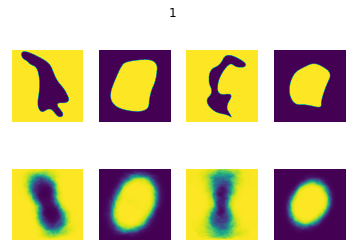

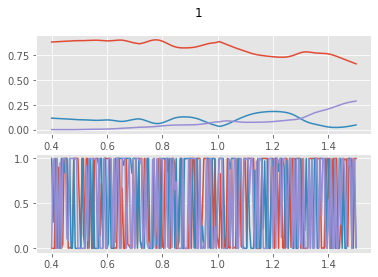

600it [00:04, 145.46it/s]


Train Loss: 10383.7044
Val Loss: 7965.7073
Epoch 2 of 100


2100it [00:48, 43.25it/s]
600it [00:03, 196.27it/s]


Train Loss: 7319.3499
Val Loss: 6412.9316
Epoch 3 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 195.21it/s]


Train Loss: 6084.4730
Val Loss: 5658.1948
Epoch 4 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 191.88it/s]


Train Loss: 5203.3391
Val Loss: 4892.8758
Epoch 5 of 100


2100it [00:48, 43.30it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 192.56it/s]

MSE loss: tensor(0.3529, device='cuda:0')


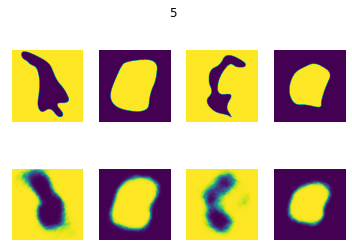

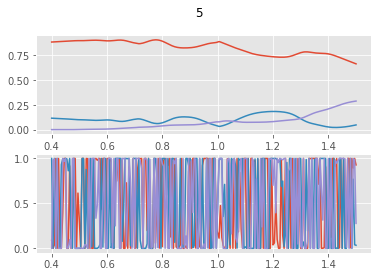

600it [00:03, 154.25it/s]


Train Loss: 4714.4165
Val Loss: 4623.6899
Epoch 6 of 100


2100it [00:48, 43.30it/s]
600it [00:03, 193.24it/s]


Train Loss: 4424.0776
Val Loss: 4380.0944
Epoch 7 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 195.03it/s]


Train Loss: 4186.1641
Val Loss: 4201.3742
Epoch 8 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 192.89it/s]


Train Loss: 3973.0607
Val Loss: 3968.2846
Epoch 9 of 100


2100it [00:48, 43.30it/s]
600it [00:03, 195.88it/s]


Train Loss: 3770.2629
Val Loss: 3910.7651
Epoch 10 of 100


2100it [00:48, 43.33it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 194.98it/s]

MSE loss: tensor(0.3353, device='cuda:0')


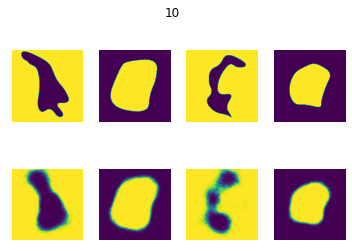

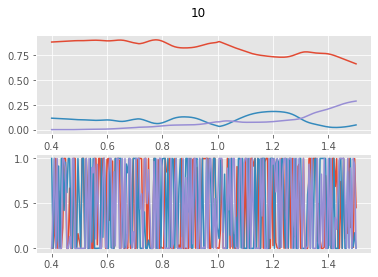

600it [00:03, 156.73it/s]


Train Loss: 3607.9696
Val Loss: 3697.4556
Epoch 11 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 195.01it/s]


Train Loss: 3485.0076
Val Loss: 3532.0117
Epoch 12 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 194.69it/s]


Train Loss: 3378.6776
Val Loss: 3458.9881
Epoch 13 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 191.73it/s]


Train Loss: 3282.5131
Val Loss: 3459.2286
Epoch 14 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 195.95it/s]


Train Loss: 3189.6621
Val Loss: 3441.6366
Epoch 15 of 100


2100it [00:48, 43.33it/s]
 67%|██████▋   | 40/60 [00:00<00:00, 192.64it/s]

MSE loss: tensor(0.3308, device='cuda:0')


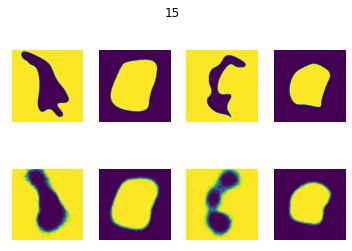

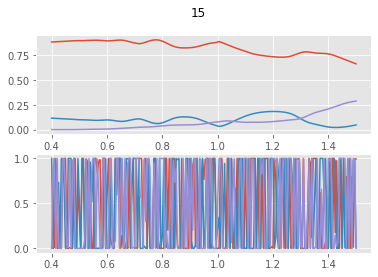

600it [00:03, 152.46it/s]


Train Loss: 3099.0581
Val Loss: 3389.3914
Epoch 16 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 192.58it/s]


Train Loss: 3021.4736
Val Loss: 3207.0940
Epoch 17 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 192.40it/s]


Train Loss: 2948.0284
Val Loss: 3197.6386
Epoch 18 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 193.84it/s]


Train Loss: 2879.6643
Val Loss: 3088.6288
Epoch 19 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 190.50it/s]


Train Loss: 2819.1780
Val Loss: 3036.3934
Epoch 20 of 100


2100it [00:48, 43.34it/s]
 95%|█████████▌| 57/60 [00:00<00:00, 185.59it/s]

MSE loss: tensor(0.3288, device='cuda:0')


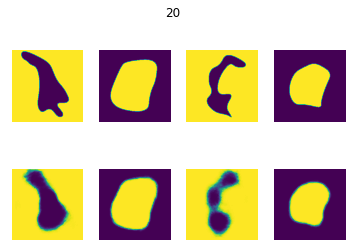

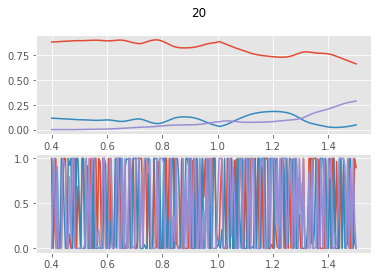

600it [00:03, 154.47it/s]


Train Loss: 2755.6815
Val Loss: 2964.6285
Epoch 21 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 192.73it/s]


Train Loss: 2700.1586
Val Loss: 2933.9243
Epoch 22 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 191.96it/s]


Train Loss: 2649.0310
Val Loss: 2934.0742
Epoch 23 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 190.73it/s]


Train Loss: 2607.2632
Val Loss: 2858.8982
Epoch 24 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 189.81it/s]


Train Loss: 2562.6050
Val Loss: 2887.1872
Epoch 25 of 100


2100it [00:48, 43.34it/s]
 67%|██████▋   | 40/60 [00:00<00:00, 193.71it/s]

MSE loss: tensor(0.3328, device='cuda:0')


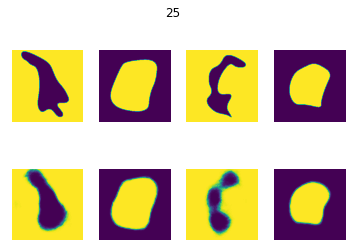

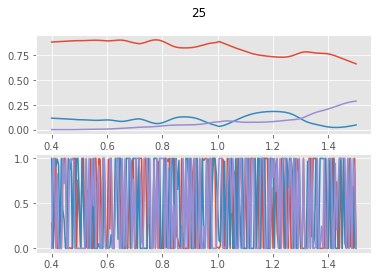

600it [00:03, 157.50it/s]


Train Loss: 2518.4138
Val Loss: 2868.0454
Epoch 26 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 194.83it/s]


Train Loss: 2481.4161
Val Loss: 2812.8773
Epoch 27 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 193.21it/s]


Train Loss: 2450.8714
Val Loss: 2773.9790
Epoch 28 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 194.33it/s]


Train Loss: 2414.8196
Val Loss: 2816.6391
Epoch 29 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 194.84it/s]


Train Loss: 2385.1809
Val Loss: 2762.8653
Epoch 30 of 100


2100it [00:48, 43.33it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 192.64it/s]

MSE loss: tensor(0.3298, device='cuda:0')


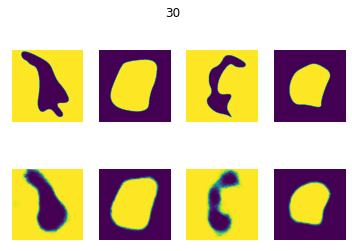

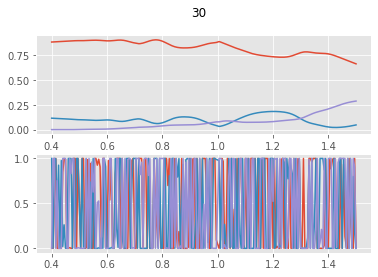

600it [00:03, 156.37it/s]


Train Loss: 2350.3354
Val Loss: 2782.1238
Epoch 31 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 192.54it/s]


Train Loss: 2319.2360
Val Loss: 2779.9879
Epoch 32 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 194.51it/s]


Train Loss: 2287.3008
Val Loss: 2714.6067
Epoch 33 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 194.18it/s]


Train Loss: 2259.3816
Val Loss: 2706.7368
Epoch 34 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 192.86it/s]


Train Loss: 2227.9996
Val Loss: 2766.4510
Epoch 35 of 100


2100it [00:48, 43.34it/s]
 67%|██████▋   | 40/60 [00:00<00:00, 196.53it/s]

MSE loss: tensor(0.3305, device='cuda:0')


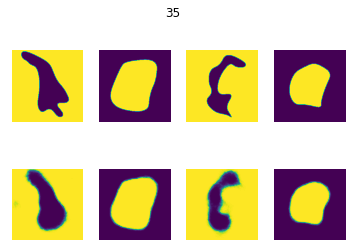

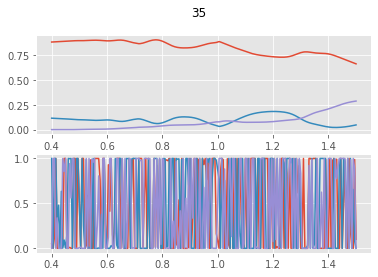

600it [00:03, 153.20it/s]


Train Loss: 2203.3824
Val Loss: 2673.1129
Epoch 36 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 195.06it/s]


Train Loss: 2182.5930
Val Loss: 2667.8982
Epoch 37 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 193.83it/s]


Train Loss: 2146.7624
Val Loss: 2695.3711
Epoch 38 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 194.07it/s]


Train Loss: 2126.5038
Val Loss: 2715.1949
Epoch 39 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 196.00it/s]


Train Loss: 2097.1831
Val Loss: 2633.0647
Epoch 40 of 100


2100it [00:48, 43.33it/s]
 97%|█████████▋| 58/60 [00:00<00:00, 189.36it/s]

MSE loss: tensor(0.3272, device='cuda:0')


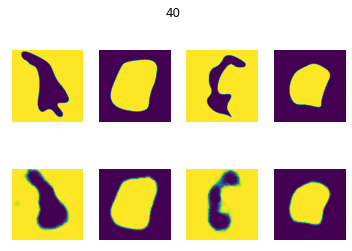

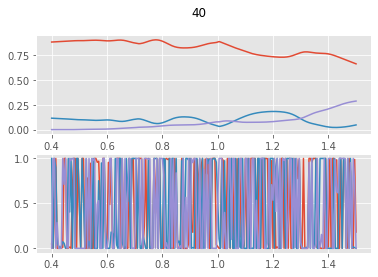

600it [00:03, 157.47it/s]


Train Loss: 2077.8007
Val Loss: 2649.0027
Epoch 41 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 194.11it/s]


Train Loss: 2058.0913
Val Loss: 2600.6517
Epoch 42 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 195.81it/s]


Train Loss: 2027.5805
Val Loss: 2615.9503
Epoch 43 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 193.55it/s]


Train Loss: 2006.8669
Val Loss: 2621.7577
Epoch 44 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 193.37it/s]


Train Loss: 1988.5812
Val Loss: 2614.2056
Epoch 45 of 100


2100it [00:48, 43.33it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 189.78it/s]

MSE loss: tensor(0.3302, device='cuda:0')


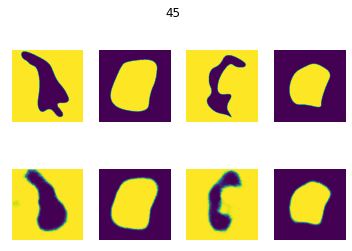

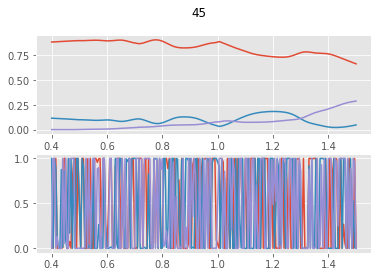

600it [00:03, 157.48it/s]


Train Loss: 1965.4032
Val Loss: 2590.2044
Epoch 46 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 195.81it/s]


Train Loss: 1946.9427
Val Loss: 2591.2319
Epoch 47 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 194.88it/s]


Train Loss: 1927.6446
Val Loss: 2595.5933
Epoch 48 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 193.74it/s]


Train Loss: 1904.0727
Val Loss: 2596.1264
Epoch 49 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 193.06it/s]


Train Loss: 1889.3417
Val Loss: 2585.0324
Epoch 50 of 100


2100it [00:48, 43.35it/s]
 65%|██████▌   | 39/60 [00:00<00:00, 191.04it/s]

MSE loss: tensor(0.3300, device='cuda:0')


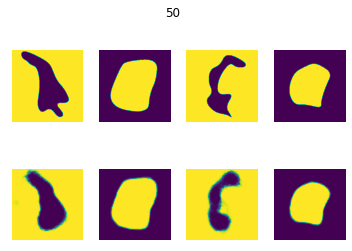

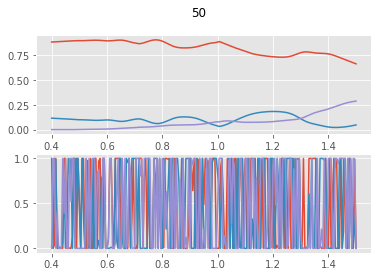

600it [00:03, 157.99it/s]


Train Loss: 1869.2980
Val Loss: 2568.2745
Epoch 51 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 195.62it/s]


Train Loss: 1849.8921
Val Loss: 2537.9102
Epoch 52 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 194.62it/s]


Train Loss: 1838.1519
Val Loss: 2563.0481
Epoch 53 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 194.23it/s]


Train Loss: 1823.8694
Val Loss: 2567.0128
Epoch 54 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 193.76it/s]


Train Loss: 1803.2720
Val Loss: 2543.7326
Epoch 55 of 100


2100it [00:48, 43.35it/s]
 95%|█████████▌| 57/60 [00:00<00:00, 189.50it/s]

MSE loss: tensor(0.3302, device='cuda:0')


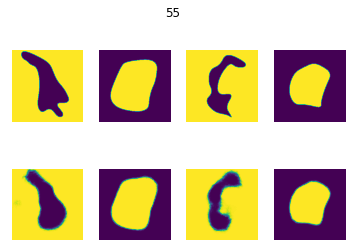

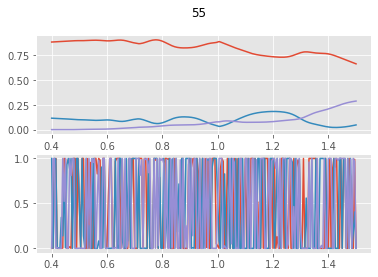

600it [00:03, 150.83it/s]


Train Loss: 1789.3246
Val Loss: 2551.4910
Epoch 56 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 193.35it/s]


Train Loss: 1770.8366
Val Loss: 2542.0750
Epoch 57 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 190.29it/s]


Train Loss: 1761.4629
Val Loss: 2563.7387
Epoch 58 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.33it/s]


Train Loss: 1737.9228
Val Loss: 2555.9832
Epoch 59 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.24it/s]


Train Loss: 1728.8799
Val Loss: 2557.9046
Epoch 60 of 100


2100it [00:48, 43.33it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 190.78it/s]

MSE loss: tensor(0.3300, device='cuda:0')


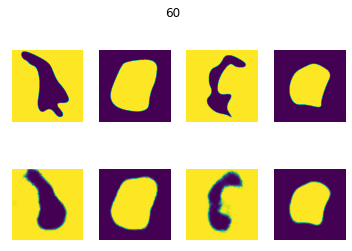

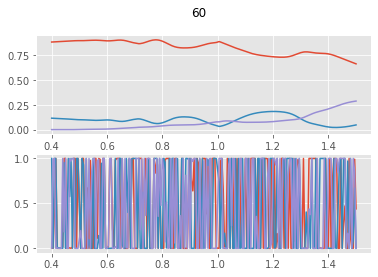

600it [00:03, 155.88it/s]


Train Loss: 1710.7440
Val Loss: 2522.5363
Epoch 61 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 190.85it/s]


Train Loss: 1703.4030
Val Loss: 2544.7917
Epoch 62 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.84it/s]


Train Loss: 1684.4603
Val Loss: 2574.5099
Epoch 63 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 190.38it/s]


Train Loss: 1670.3579
Val Loss: 2558.3010
Epoch 64 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 191.70it/s]


Train Loss: 1661.5510
Val Loss: 2609.2331
Epoch 65 of 100


2100it [00:48, 43.35it/s]
 65%|██████▌   | 39/60 [00:00<00:00, 192.88it/s]

MSE loss: tensor(0.3326, device='cuda:0')


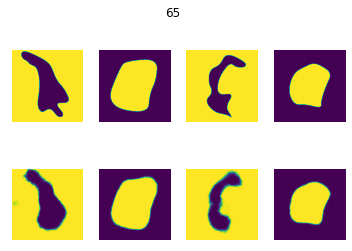

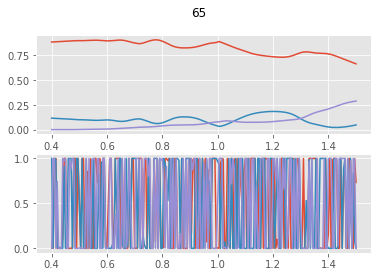

600it [00:03, 155.14it/s]


Train Loss: 1645.0641
Val Loss: 2617.0130
Epoch 66 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 190.76it/s]


Train Loss: 1629.7067
Val Loss: 2554.5721
Epoch 67 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 192.67it/s]


Train Loss: 1627.4509
Val Loss: 2619.0789
Epoch 68 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 194.06it/s]


Train Loss: 1606.3497
Val Loss: 2544.6397
Epoch 69 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 193.40it/s]


Train Loss: 1591.3347
Val Loss: 2571.7956
Epoch 70 of 100


2100it [00:48, 43.34it/s]
 90%|█████████ | 54/60 [00:00<00:00, 181.11it/s]

MSE loss: tensor(0.3341, device='cuda:0')


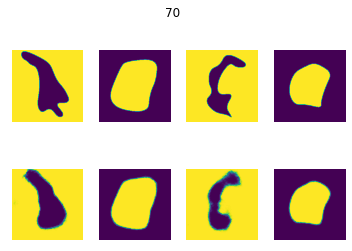

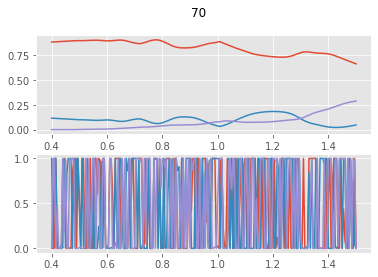

600it [00:04, 149.06it/s]


Train Loss: 1582.5994
Val Loss: 2562.4726
Epoch 71 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 190.36it/s]


Train Loss: 1571.8055
Val Loss: 2579.8159
Epoch 72 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 190.73it/s]


Train Loss: 1564.2062
Val Loss: 2581.1900
Epoch 73 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 190.23it/s]


Train Loss: 1550.4819
Val Loss: 2570.7529
Epoch 74 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 190.83it/s]


Train Loss: 1536.5106
Val Loss: 2552.1863
Epoch 75 of 100


2100it [00:48, 43.34it/s]
 95%|█████████▌| 57/60 [00:00<00:00, 186.04it/s]

MSE loss: tensor(0.3318, device='cuda:0')


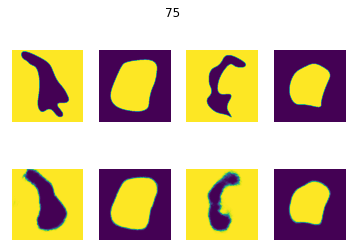

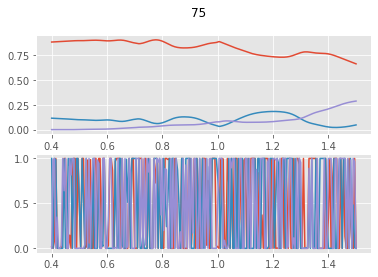

600it [00:03, 155.29it/s]


Train Loss: 1531.6050
Val Loss: 2581.4000
Epoch 76 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.35it/s]


Train Loss: 1520.9427
Val Loss: 2583.8004
Epoch 77 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 191.45it/s]


Train Loss: 1510.3148
Val Loss: 2565.0149
Epoch 78 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 190.80it/s]


Train Loss: 1504.1722
Val Loss: 2538.9157
Epoch 79 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 190.96it/s]


Train Loss: 1485.8773
Val Loss: 2593.4897
Epoch 80 of 100


2100it [00:48, 43.34it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 192.70it/s]

MSE loss: tensor(0.3337, device='cuda:0')


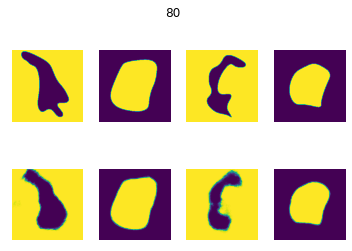

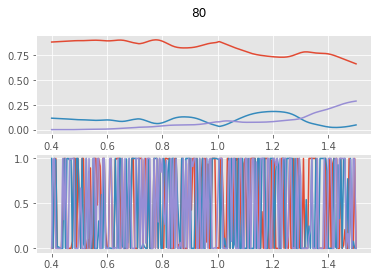

600it [00:03, 155.25it/s]


Train Loss: 1478.7277
Val Loss: 2602.5039
Epoch 81 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.60it/s]


Train Loss: 1465.4984
Val Loss: 2598.7447
Epoch 82 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.08it/s]


Train Loss: 1460.8135
Val Loss: 2581.9961
Epoch 83 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 190.82it/s]


Train Loss: 1451.8192
Val Loss: 2614.5031
Epoch 84 of 100


2100it [00:48, 43.35it/s]
600it [00:03, 191.13it/s]


Train Loss: 1442.3024
Val Loss: 2616.6448
Epoch 85 of 100


2100it [00:48, 43.34it/s]
 93%|█████████▎| 56/60 [00:00<00:00, 183.51it/s]

MSE loss: tensor(0.3336, device='cuda:0')


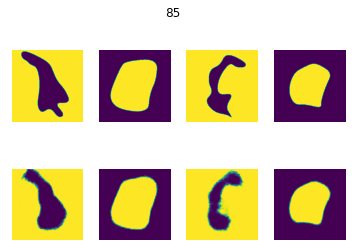

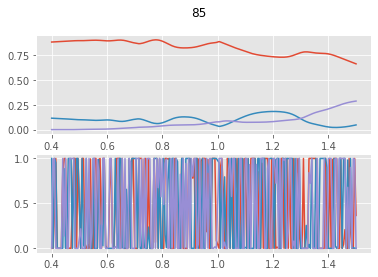

600it [00:03, 155.59it/s]


Train Loss: 1433.9088
Val Loss: 2582.8603
Epoch 86 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.32it/s]


Train Loss: 1418.5199
Val Loss: 2586.8231
Epoch 87 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 191.62it/s]


Train Loss: 1415.1619
Val Loss: 2741.7981
Epoch 88 of 100


2100it [00:48, 43.34it/s]
600it [00:03, 191.63it/s]


Train Loss: 1403.6587
Val Loss: 2700.4503
Epoch 89 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 189.97it/s]


Train Loss: 1401.9106
Val Loss: 2647.5616
Epoch 90 of 100


2100it [00:48, 43.34it/s]
 97%|█████████▋| 58/60 [00:00<00:00, 189.54it/s]

MSE loss: tensor(0.3333, device='cuda:0')


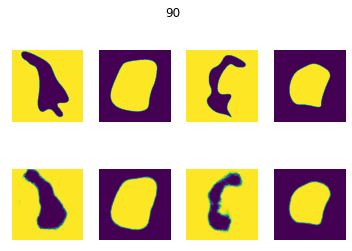

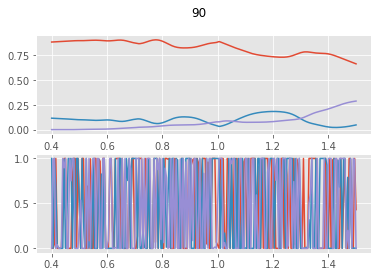

600it [00:03, 150.85it/s]


Train Loss: 1385.1153
Val Loss: 2623.0747
Epoch 91 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 191.09it/s]


Train Loss: 1381.5721
Val Loss: 2599.6135
Epoch 92 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 190.90it/s]


Train Loss: 1370.5762
Val Loss: 2621.6517
Epoch 93 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 191.58it/s]


Train Loss: 1363.4534
Val Loss: 2655.7866
Epoch 94 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 194.95it/s]


Train Loss: 1355.2191
Val Loss: 2669.3331
Epoch 95 of 100


2100it [00:48, 43.33it/s]
 95%|█████████▌| 57/60 [00:00<00:00, 187.55it/s]

MSE loss: tensor(0.3329, device='cuda:0')


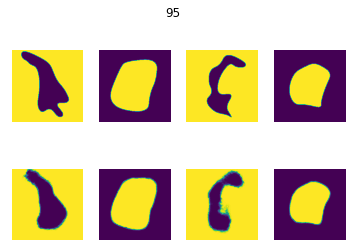

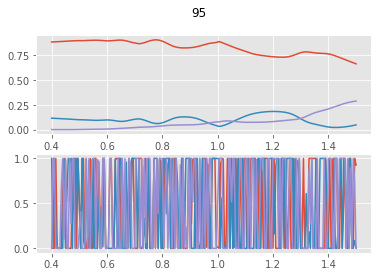

600it [00:03, 154.91it/s]


Train Loss: 1346.5938
Val Loss: 2670.7748
Epoch 96 of 100


2100it [00:48, 43.33it/s]
600it [00:03, 194.00it/s]


Train Loss: 1340.2004
Val Loss: 2602.7330
Epoch 97 of 100


2100it [00:48, 43.32it/s]
600it [00:03, 189.80it/s]


Train Loss: 1336.6993
Val Loss: 2659.5708
Epoch 98 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 191.54it/s]


Train Loss: 1322.5612
Val Loss: 2649.8070
Epoch 99 of 100


2100it [00:48, 43.31it/s]
600it [00:03, 192.81it/s]


Train Loss: 1316.6069
Val Loss: 2642.1534
Epoch 100 of 100


2100it [00:48, 43.32it/s]
 98%|█████████▊| 59/60 [00:00<00:00, 191.75it/s]

MSE loss: tensor(0.3350, device='cuda:0')


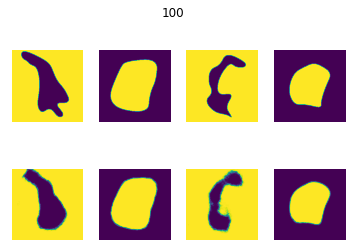

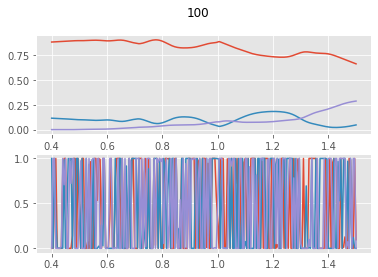

600it [00:03, 156.11it/s]

Train Loss: 1305.6441
Val Loss: 2639.8706


In [ ]:

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model_custom, train_dataloader)
    if epoch == 0 or not ((epoch+1) % 5):
      val_epoch_loss = validate(model_custom, valid_dataloader, 1)
    else:
      val_epoch_loss = validate(model_custom, valid_dataloader, 0)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")